In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col, udf, rand
import matplotlib.pyplot as plt
import math
import pyspark.sql as ps
from zlib import crc32
import time as tm
from datetime import datetime as dt
import itertools
from dataclasses import dataclass
from pyspark.sql import functions as F
from pyspark.rdd import RDD
from pyspark.broadcast import Broadcast
import findspark

In [3]:
path = './data'
worker_nodes = "*"
problem_to_solve = 'CANCELLED'

dataset_limit = 10000
use_all_dataset_frames = True
number_of_splits = 10

# DA SCRIVERE
- perche' usiamo i dataframe invece degli rdd nella prima parte
- aggiungere k fold cross validation
- aggiungere griglia parametri
- aggiungere label stratification
- aggiungere performance modello pyspark
- aggiungere check e info extra su dataset di base (es sbilanciamento)
- auroc, auprc, f1, 
- confronto con tree classifier

## Data Download

In [4]:
os.environ['KAGGLE_USERNAME'] = "davidetricella"
os.environ['KAGGLE_KEY'] = "e1ab3aae4a07f36b37a3a8bace74d9df"


dataset = 'yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018'
path = './data'

In [5]:
def download_dataset():
    if not os.path.isdir(path):
        os.mkdir(path)
    if not os.listdir(path):
        try:
            api = KaggleApi()
            api.authenticate()
            api.dataset_download_files(dataset, path, unzip=True, quiet=False)
        except:
            print("Error downloading the dataset")

## Data Loading

In [6]:
dataframe_schema = StructType([
    StructField('FL_DATE', StringType(), True),
    StructField('OP_CARRIER', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('CRS_DEP_TIME', StringType(), True),
    StructField('CRS_ARR_TIME', StringType(), True),
    StructField('CANCELLED', StringType(), True),
    StructField('DIVERTED', StringType(), True),
    StructField('CRS_ELAPSED_TIME', StringType(), True),
    StructField('DISTANCE', StringType(), True)
])

columns_to_get = [
    'FL_DATE',
    'OP_CARRIER',
    'ORIGIN',
    'DEST',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME',
    'CANCELLED',
    'DIVERTED',
    'CRS_ELAPSED_TIME',
    'DISTANCE'
]

findspark.init()
findspark.find()

spark = SparkSession.builder \
.appName("Airline Departure") \
.master('local[' + worker_nodes + ']') \
.getOrCreate()

context = spark.sparkContext

In [7]:
def load_dataset():
    data = spark.read.format("csv") \
        .option("header", True) \
        .load(path + '/preprocessed')

    print('Preprocessed dataset loaded')
    return data

def save_dataset(data):
    data.write.format('csv').option('header', True).mode('overwrite').option(
        'sep', ',').save(path + '/preprocessed')
    print('Preprocessed dataset saved')

def check_preprocessed_data_exists() -> bool:
    files = os.listdir('./data')
    for f in files:
        if f.startswith('preprocessed'):
            return True
    return False

def get_dataset(limit: float = -1, allFrames: bool = True):
    files = os.listdir(path)
    big_frame = spark.createDataFrame(
        spark.sparkContext.emptyRDD(), schema=dataframe_schema)
    if not allFrames:
        files = [files[0]]

    for f in files:
        if f.endswith('.csv'):
            frame = spark.read.option("header", True).csv(path + '/' + f)
            frame = frame.select(columns_to_get)
            frame = frame.orderBy(rand())

            if limit != -1:
                frame = frame.limit(limit)

            big_frame = frame.union(big_frame)

    big_frame = big_frame.select(
        "*").withColumn("index", monotonically_increasing_id())
    big_frame.count()

    return big_frame


## Preprocessing

In [8]:
default_values = {
    'CANCELLED': 0,
    'DIVERTED': 0
}

columns_to_remove_for_canceled = [
    'DIVERTED',  # the flight has been diverted to an unplanned airport
]

columns_to_remove_for_diverted = [
    'CANCELLED',  # the flight has been cancelled
]

names_columns_to_convert = [
    'OP_CARRIER',
    'ORIGIN',
    'DEST',
]

date_columns_to_convert = [
    'FL_DATE'
]

time_columns_to_convert = [
    'CRS_DEP_TIME',
    'CRS_ARR_TIME',
    'CRS_ELAPSED_TIME'
]

numeric_columns_to_convert = [
    'DISTANCE'
]

string_columns_to_convert = [
    'CANCELLED',
    'DIVERTED'
]

preprocess_columns_to_convert = [
    'OP_CARRIER',
    'ORIGIN',
    'DEST',
    'FL_DATE',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME',
    'CRS_ELAPSED_TIME',
    'DISTANCE',
    'CANCELLED',
    'DIVERTED',
    'index'
]

max_distance = 4970

In [9]:
#CHARTS PLOTTING
def plot_balancing_chart(data: ps.DataFrame, label: str):
  total_positives = data.filter(col(label) == 1).count()
  total_negatives = data.filter(col(label) == 0).count()
  fig, ax = plt.subplots()

  labels = ['REGULAR', label]
  counts = [total_negatives, total_positives]
  bar_colors = ['tab:blue', 'tab:red']

  ax.bar(labels, counts, color=bar_colors)

  ax.set_ylabel('Counts')
  ax.set_title('Regular flights and problematic flights counts')

  plt.show()


In [27]:
def print_and_save_time(s: str):
    time_file.write(s + '\n')
    print(s)


def remove_extra_columns(index: str, data: ps.DataFrame) -> ps.DataFrame:

    start_time = tm.time()
    oppositeIndex = 'DIVERTED' if index == 'CANCELLED' else 'CANCELLED'
    data = data.drop(oppositeIndex)
    data = data.drop('index')
    data.count()

    finish_time = tm.time() - start_time
    print_and_save_time("Extra column removal concluded: " +
                        str(finish_time) + " seconds")
    return data


def convert_strings_into_numbers(data: ps.DataFrame) -> ps.DataFrame:
    udf_string_conversion = udf(lambda x: float(x), DoubleType())
    for c in string_columns_to_convert:
        data = data.withColumn(c, udf_string_conversion(col(c)))
    data.count()
    return data


def convert_names_into_numbers(data: ps.DataFrame) -> ps.DataFrame:

    def str_to_float(s: str):
        encoding = "utf-8"
        b = s.encode(encoding)
        return float(crc32(b) & 0xffffffff) / 2**32

    udf_names_conversion = udf(lambda x: str_to_float(x), DoubleType())
    for c in names_columns_to_convert:
        data = data.withColumn(c, udf_names_conversion(col(c)))
    data.count()
    return data


def convert_dates_into_numbers(data: ps.DataFrame) -> ps.DataFrame:
    multiplier: float = 1 / 365

    def date_to_day_of_year(date_string) -> float:

        date = dt.strptime(date_string, "%Y-%m-%d")
        day = date.timetuple().tm_yday - 1
        return day * multiplier

    udf_dates_conversion = udf(
        lambda x: date_to_day_of_year(x), DoubleType())
    for c in date_columns_to_convert:
        data = data.withColumn(c, udf_dates_conversion(col(c)))
    data.count()

    return data

def balance_dataframe(data: ps.DataFrame, index: str) -> ps.DataFrame:
    start_time = tm.time()
    irregular_flights = data.filter(col(index) == 1)
    regular_flights = data.filter(col(index) == 0)

    result = regular_flights.limit(irregular_flights.count()).\
        union(irregular_flights).\
        orderBy(rand())

    finish_time = tm.time() - start_time
    print_and_save_time("Dataset balancing concluded: " +
                        str(finish_time) + " seconds")
    return result

#DA CONVERTIRE SENZA UDF
def convert_times_into_numbers(data: ps.DataFrame) -> ps.DataFrame:

    def time_to_interval(time) -> float:
        t = int(float(time))
        h = t // 100
        m = t % 100
        t = h * 60 + m
        return float(t / 1140)

    udf_time_conversion = udf(lambda x: time_to_interval(x), DoubleType())
    for c in time_columns_to_convert:
        data = data.withColumn(c, udf_time_conversion(col(c)))
    data.count()

    return data

#DA CONVERTIRE SENZA UDF
def convert_distance_into_numbers(data: ps.DataFrame) -> ps.DataFrame:

    multiplier: float = float(1) / float(max_distance)
    udf_numeric_conversion = udf(
        lambda x: float(x) * multiplier, DoubleType())

    data = data.withColumn(
        'DISTANCE', udf_numeric_conversion(col('DISTANCE')))
    data.count()
    return data


def z_score_normalize(data: ps.DataFrame) -> ps.DataFrame:
    pass



def split_data(data: ps.DataFrame, label: str, k: int) -> tuple[ps.DataFrame, ps.DataFrame]:
    split_list = []

    data = data.dropDuplicates()

    k_elements_half_number = math.floor((data.count() / k) / 2)

    i = 0
    while i < k:
        k_positive_sample = data.where(
            col(label) == 1).limit(k_elements_half_number)
        k_negative_sample = data.where(
            col(label) == 0).limit(k_elements_half_number)
        k_sample = k_positive_sample.union(k_negative_sample)

        split_list.append(k_sample)
        data = data.subtract(k_sample)

        print("Split " + str(i + 1) + " of " + str(k) + " completed")
        i += 1

    return split_list

#else:
#    data = load_dataset()
#    udf_string_conversion = udf(lambda x: float(x), DoubleType())
#    for c in preprocess_columns_to_convert:
#        data = data.withColumn(c, udf_string_conversion(col(c)))
    


In [11]:
#PREPROCESSING EXECUTION
time_file = open("./data/times.txt", "w")

#if not check_preprocessed_data_exists():
download_dataset()
start_time = tm.time()
data = get_dataset(dataset_limit, use_all_dataset_frames)

finish_time = tm.time() - start_time
print_and_save_time("Dataset reading concluded: " +
                    str(finish_time) + " seconds")

Dataset reading concluded: 13.62911343574524 seconds


In [12]:
# Remove rows with Nan key values
common_start_time = tm.time()

data = data.dropna(how='any')
null_removal_finish_time = tm.time() - common_start_time
print_and_save_time("Null values removal concluded: " +
                    str(null_removal_finish_time) + " seconds")

Null values removal concluded: 0.026459217071533203 seconds


In [13]:
data = balance_dataframe(data, problem_to_solve)

Dataset balancing concluded: 28.340028285980225 seconds


In [14]:
names_start_time = tm.time()
data = convert_names_into_numbers(data)
names_finish_time = tm.time() - names_start_time
print_and_save_time("Names conversion concluded: " +
                    str(names_finish_time) + " seconds")

Names conversion concluded: 54.98914456367493 seconds


In [15]:
dates_start_time = tm.time()
data = convert_dates_into_numbers(data)
dates_finish_time = tm.time() - dates_start_time
print_and_save_time("Dates conversion concluded: " +
                    str(dates_finish_time) + " seconds")

Dates conversion concluded: 52.610299587249756 seconds


In [16]:
times_start_time = tm.time()
data = convert_times_into_numbers(data)
times_finish_time = tm.time() - times_start_time
print_and_save_time("Times conversion concluded: " +
                    str(times_finish_time) + " seconds")

Times conversion concluded: 55.34258413314819 seconds


In [17]:
distance_start_time = tm.time()
data = convert_distance_into_numbers(data)
distance_finish_time = tm.time() - distance_start_time
print_and_save_time("Distance conversion concluded: " +
                    str(distance_finish_time) + " seconds")

Distance conversion concluded: 55.27087140083313 seconds


In [18]:
strings_start_time = tm.time()
data = convert_strings_into_numbers(data)
strings_finish_time = tm.time() - strings_start_time
print_and_save_time("Strings conversion concluded: " +
                    str(strings_finish_time) + " seconds")

Strings conversion concluded: 57.37093949317932 seconds


In [19]:
save_dataset(data)

Py4JJavaError: An error occurred while calling o435.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:638)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 436.0 failed 1 times, most recent failure: Lost task 0.0 in stage 436.0 (TID 2432) (192.168.1.89 executor driver): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:348)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:111)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:155)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:53)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:245)
	... 41 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:348)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:111)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:155)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:295)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:307)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:53)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:272)


In [20]:
data = remove_extra_columns(problem_to_solve, data)

Extra column removal concluded: 52.0863401889801 seconds


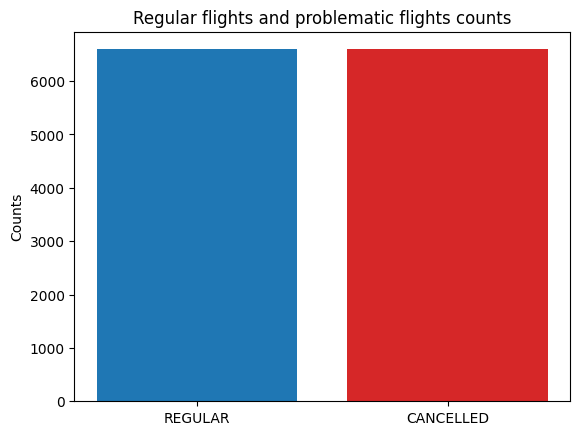

In [21]:
plot_balancing_chart(data, problem_to_solve)

In [44]:
data.select(F.col('OP_CARRIER')).show()

+--------------------+
|          OP_CARRIER|
+--------------------+
| 0.35488015157170594|
|  0.8907070874702185|
| 0.29755657189525664|
|   0.530499154701829|
|  0.6213391446508467|
|  0.6588134847115725|
| 0.29648267361335456|
| 0.46551953721791506|
|  0.3311674117576331|
|  0.8138902904465795|
|0.009918806841596961|
|  0.6213391446508467|
|  0.3311674117576331|
|  0.6188511815853417|
| 0.29648267361335456|
|  0.6213391446508467|
|  0.6797474827617407|
| 0.29755657189525664|
|   0.699212800944224|
| 0.33370711258612573|
+--------------------+
only showing top 20 rows



### Z Score Normalization

In [45]:
column_list = data.columns
column_mean_dict = dict()
column_stddv_dict = dict()

for c in column_list:
    column_mean_dict[c] = data.select(F.mean(F.col(c))).head()[0]
    column_stddv_dict[c] = data.select(F.stddev(F.col(c))).head()[0]

data = data.select(
    problem_to_solve,

    ((data.OP_CARRIER - column_mean_dict["OP_CARRIER"]) / column_stddv_dict["OP_CARRIER"]).alias('OP_CARRIER'),

    ((data.ORIGIN - column_mean_dict["ORIGIN"]) / column_stddv_dict["ORIGIN"]).alias('ORIGIN'),

    ((data.DEST - column_mean_dict["DEST"]) / column_stddv_dict["DEST"]).alias('DEST'),

    ((data.FL_DATE - column_mean_dict["FL_DATE"]) / column_stddv_dict["FL_DATE"]).alias('FL_DATE'),

    ((data.CRS_DEP_TIME - column_mean_dict["CRS_DEP_TIME"]) / column_stddv_dict["CRS_DEP_TIME"]).alias('CRS_DEP_TIME'),

    ((data.CRS_ARR_TIME - column_mean_dict["CRS_ARR_TIME"]) /  column_stddv_dict["CRS_ARR_TIME"]).alias('CRS_ARR_TIME'),

    ((data.CRS_ELAPSED_TIME - column_mean_dict["CRS_ELAPSED_TIME"]) / column_stddv_dict["CRS_ELAPSED_TIME"]).alias('CRS_ELAPSED_TIME'),

    ((data.DISTANCE - column_mean_dict["DISTANCE"]) / column_stddv_dict["DISTANCE"]).alias('DISTANCE')
    )

OP_CARRIER


In [ ]:
start_time = tm.time()
preprocessing_splits = split_data(data, problem_to_solve, number_of_splits)

finish_time = tm.time() - start_time
print_and_save_time("Dataset splitting concluded: " +
                    str(finish_time) + " seconds")


Bonus: Pandas

In [ ]:
def pandas_load_dataset():
    data = pd.read_csv(filepath_or_buffer=path + '/' + 'preprocessed.csv')
    print('Preprocessed dataset loaded')
    return data

def pandas_save_dataset(data):
    data.to_csv(path_or_buf=path + '/' + 'preprocessed.csv', index=False)
    print('Preprocessed dataset saved')

def pandas_get_dataset(limit: float = -1, allFrames: bool = True):
    files = os.listdir(path)
    big_frame = pd.DataFrame()

    if not allFrames:
        files = [files[0]]

    for f in files:
        if f.endswith('.csv'):
            frame = pd.read_csv(filepath_or_buffer=path +
                                '/' + f, usecols=columns_to_get)
            if limit != -1:
                frame = frame.sample(n=limit, replace=False)
            big_frame = pd.concat([big_frame, frame])
    return big_frame


def pandas_remove_extra_columns(index: str, data: pd.DataFrame) -> pd.DataFrame:

    start_time = tm.time()
    oppositeIndex = 'DIVERTED' if index == 'CANCELLED' else 'CANCELLED'
    data.drop(oppositeIndex, axis=1, inplace=True)

    finish_time = tm.time() - start_time
    print_and_save_time("Extra column removal concluded: " +
                        str(finish_time) + " seconds")
    return data


def pandas_balance_dataframe(data: pd.DataFrame, index: str) -> pd.DataFrame:
    start_time = tm.time()
    irregulars = data.query(index + ' == 1')
    regulars = data.query(index + ' == 0')
    
    result = pd.concat([regulars.sample(len(irregulars)), irregulars]).sample(frac=1)
    finish_time = tm.time() - start_time
    print_and_save_time("Dataset balancing concluded: " +
                        str(finish_time) + " seconds")
    return result


def pandas_convert_names_into_numbers(data: pd.DataFrame) -> pd.DataFrame:

    def str_to_float(s: str):
        encoding = "utf-8"
        b = s.encode(encoding)
        return float(crc32(b) & 0xffffffff) / 2**32

    for c in names_columns_to_convert:
        data[c] = data[c].apply(str_to_float)
    return data


def pandas_convert_dates_into_numbers(data: pd.DataFrame) -> pd.DataFrame:
    multiplier: float = 1 / 365

    def date_to_day_of_year(date_string) -> float:
        date = dt.strptime(date_string, "%Y-%m-%d")
        day = date.timetuple().tm_yday - 1
        return day * multiplier

    for i in date_columns_to_convert:
        data[i] = data[i].apply(date_to_day_of_year)

    return data


def pandas_convert_times_into_numbers(data: pd.DataFrame) -> pd.DataFrame:

    def time_to_interval(time) -> float:
        t = int(float(time))
        h = t // 100
        m = t % 100
        t = h * 60 + m
        return float(t / 1140)

    for c in time_columns_to_convert:
        data[c] = data[c].apply(time_to_interval)

    return data


def pandas_convert_distance_into_numbers(data: pd.DataFram) -> pd.DataFrame:

    multiplier: float = float(1) / float(max_distance)

    for c in numeric_columns_to_convert:
        data[c] = data[c].apply(lambda x: x * multiplier)
    return data


def pandas_split_data(data: pd.DataFrame, label: str, k: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    split_list = []

    data.drop_duplicates(inplace=True)

    irregulars = data.query(label + ' == 1')
    regulars = data.query(label + ' == 0')

    k_elements_half_number = round((len(data) / k) / 2)

    for i in range(1, k + 1):
        k_irregulars_sample = irregulars.head(k_elements_half_number)
        k_regulars_sample = regulars.head(k_elements_half_number)
        k_sample = pd.concat([k_irregulars_sample, k_regulars_sample])

        split_list.append(k_sample.to_numpy())
        irregulars = irregulars.drop(k_irregulars_sample.index)
        regulars = regulars.drop(k_regulars_sample.index)

    return split_list

def pandas_common_preprocess(data: ps.DataFrame | pd.DataFrame) -> ps.DataFrame | pd.DataFrame:

    common_start_time = tm.time()

    data.dropna(how='any', axis='index', inplace=True)

    null_removal_finish_time = tm.time() - common_start_time
    print_and_save_time("Null values removal concluded: " +
                        str(null_removal_finish_time) + " seconds")

    pandas_balance_dataframe(data, problem_to_solve)

    names_start_time = tm.time()
    data = pandas_convert_names_into_numbers(data)
    names_finish_time = tm.time() - names_start_time
    print_and_save_time("Names conversion concluded: " +
                        str(names_finish_time) + " seconds")

    dates_start_time = tm.time()
    data = pandas_convert_dates_into_numbers(data)
    dates_finish_time = tm.time() - dates_start_time
    print_and_save_time("Dates conversion concluded: " +
                        str(dates_finish_time) + " seconds")

    times_start_time = tm.time()
    data = pandas_convert_times_into_numbers(data)
    times_finish_time = tm.time() - times_start_time
    print_and_save_time("Times conversion concluded: " +
                        str(times_finish_time) + " seconds")

    distance_start_time = tm.time()
    data = pandas_convert_distance_into_numbers(data)
    distance_finish_time = tm.time() - distance_start_time
    print_and_save_time("Distance conversion concluded: " +
                        str(distance_finish_time) + " seconds")

    common_finish_time = tm.time() - common_start_time
    print_and_save_time("Common preprocessing concluded: " +
                        str(common_finish_time) + " seconds")
    return data

if not check_preprocessed_data_exists():
        download_dataset()

        start_time = tm.time()
        data = get_dataset(dataset_limit, use_all_dataset_frames)

        finish_time = tm.time() - start_time
        print_and_save_time("Dataset reading concluded: " +
                            str(finish_time) + " seconds")

        data = pandas_common_preprocess(data)
        pandas_save_dataset(data)
else:
    data = pandas_load_dataset()
    
data = pandas_remove_extra_columns(problem_to_solve, data)

start_time = tm.time()
preprocessing_splits = pandas_split_data(data, problem_to_solve, number_of_splits)

finish_time = tm.time() - start_time
print_and_save_time("Dataset splitting concluded: " +
                    str(finish_time) + " seconds")

## Models

### Generic Functions

In [ ]:
def sigmoid(x):
    '''
    Calculates the sigmoid of the given data
    '''
    g = 1.0 / (1.0 + np.exp(-x))
    return g

def binary_cross_entropy(y, y_label, w, l2):
    '''
    Calculates the binary cross entropy loss of the calculated y and the given y_label
    '''
    loss = -np.mean(y_label*(np.log(y)) + (1-y_label)
                    * np.log(1-y)) + regularize(w, l2)
    return loss

def regularize(W, l2):
    '''
    Calculates the regularization term for the loss
    '''
    return (l2 / 2) * np.sum(np.square(W))

### Parallel Model

In [ ]:
@dataclass
class ParallelLogisticRegression:
    iterations: int
    learning_rate: float
    batch_size: int
    l2: float
    W: Broadcast
    b: float

def initialize(self: ParallelLogisticRegression, size):
    self.W = context.broadcast(np.random.rand(size))
    self.b = np.random.rand()


def parallel_train(self: ParallelLogisticRegression, data: ps.DataFrame):
    initialize(self, len(data.columns) - 1)

    num_chunks = X.count() // self.batch_size
    chunk_percent = 1/num_chunks

    batches = data.randomSplit([chunk_percent] * num_chunks)

    Y_labels = [b.select(problem_to_solve).rdd for b in batches]
    X = [b.drop(problem_to_solve).rdd for b in batches]

    losses = []
    gradients = []

    for _ in range(self.iterations):
        _losses = []
        _gradients = [] 

        for b_X, b_Y_labels in zip(X, Y_labels):
            Y = self.evaluate(b_X)
            _losses.append(binary_cross_entropy(
                Y, b_Y_labels, self.W, self.l2))
            (dW, db) = self.gradient(b_X, Y, b_Y_labels)
            _gradients.append(dW)
            self.update(dW, db)
        losses.append(np.mean(_losses))
        gradients.append(np.mean(_gradients))

        return (losses, gradients)

def parallel_evaluate(self: ParallelLogisticRegression, X: RDD):
    Z = X.map(lambda x: np.dot(x, self.W.value)).reduce(lambda a, b: a+b + self.b)
    Z = Z.map(lambda x: sigmoid(x))
    return Z
        
def update(self, dW: list[float], db: float):
        self.W = context.broadcast(self.W.value - self.learning_rate * dW)
        self.b = self.b - self.learning_rate * db

### Serial Model

In [ ]:
class SerialLogisticRegression():
    def __init__(self, iterations: int, learning_rate: float, batch_size: int, l2: float):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.l2 = l2

    def initialize(self, columns_number):
        self.W = np.random.rand(columns_number)
        self.b = np.random.rand()

    def evaluate(self, X):
        Z = np.dot(X, self.W) + self.b
        Z = sigmoid(Z)
        return Z

    def gradient(self, X, Y, Y_label):
        '''
        Calculates the gradient w.r.t weights and bias
        '''

        # Number of training examples.
        m = X.shape[0]

        # Gradient of loss w.r.t weights with regularization
        dw = (1/m)*np.dot(X.T, (Y - Y_label)) + self.l2 * self.W

        # Gradient of loss w.r.t bias with regularization
        db = (1/m)*np.sum((Y - Y_label))

        return dw, db

    def update(self, dW, db):
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db

    def train(self, X, Y_labels, iterations = 10):
        self.initialize(X.shape[1])
        losses = []
        gradients = []

        for _ in range(iterations):
            _losses = []
            _gradients = []
            for b in range(X.shape[0]//self.batch_size):
                b_X = X[b*self.batch_size:b*self.batch_size+self.batch_size, :]
                b_Y_labels = Y_labels[b*self.batch_size:b *
                                      self.batch_size+self.batch_size]
                Y = self.evaluate(b_X)
                _losses.append(binary_cross_entropy(
                    Y, b_Y_labels, self.W, self.l2))
                (dW, db) = self.gradient(b_X, Y, b_Y_labels)
                _gradients.append(dW)
                self.update(dW, db)
            losses.append(np.mean(_losses))
            gradients.append(np.mean(_gradients))

        return (losses, gradients)

## Experiments


In [ ]:
def make_roc(labels, results, name):
    labels_and_results = sorted(
        list(zip(labels, map(lambda x: x, results))), key=lambda x: x[1])

    labels_by_weights = np.array([k for (k, _) in labels_and_results])

    length = labels_by_weights.size

    true_positives = labels_by_weights.cumsum()

    num_positive = true_positives[-1]

    false_positives = np.arange(1.0, length + 1, 1.) - true_positives

    true_positives_rate = true_positives / num_positive
    false_positives_rate = false_positives / (length - num_positive)

    fig, ax = plt.subplots()
    ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    plt.plot(false_positives_rate, true_positives_rate,
             color='#8cbfd0', linestyle='-', linewidth=3.)
    plt.plot((0., 1.), (0., 1.), linestyle='--',
             color='#d6ebf2', linewidth=2.)

    plt.savefig('./data/{}_roc.png'.format(name))
    fig.clear()
    plt.close()

def plot_loss_gradient(iterations, train_losses, gradients, name):
    fig, ax = plt.subplots()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss/Gradient')
    ax.set_title(name)
    ax.plot(range(iterations), train_losses, label='Loss')
    ax.plot(range(iterations), gradients, label='Gradient')
    ax.grid()
    ax.legend()

    fig.savefig("./data/{}.png".format(name))
    fig.clear()
    plt.close()

### Hyperparamters Tuning

In [ ]:
grid = { 'iter': [100, 200, 500], 'lr': [0.001, 0.01, 0.1], 'l2': [0, 0.1, 0.001], 'batch_size': [0, 20]}

params = list(itertools.product(*grid.values()))

params

[(100, 0.001, 0),
 (100, 0.001, 0.1),
 (100, 0.001, 0.001),
 (100, 0.01, 0),
 (100, 0.01, 0.1),
 (100, 0.01, 0.001),
 (100, 0.1, 0),
 (100, 0.1, 0.1),
 (100, 0.1, 0.001),
 (200, 0.001, 0),
 (200, 0.001, 0.1),
 (200, 0.001, 0.001),
 (200, 0.01, 0),
 (200, 0.01, 0.1),
 (200, 0.01, 0.001),
 (200, 0.1, 0),
 (200, 0.1, 0.1),
 (200, 0.1, 0.001),
 (500, 0.001, 0),
 (500, 0.001, 0.1),
 (500, 0.001, 0.001),
 (500, 0.01, 0),
 (500, 0.01, 0.1),
 (500, 0.01, 0.001),
 (500, 0.1, 0),
 (500, 0.1, 0.1),
 (500, 0.1, 0.001)]

In [ ]:

class Evaluator:
    def __init__(self, iterations, lr, l2, batch_size):
        self.iterations = iterations
        self.lr = lr
        self.l2 = l2
        self.batch_size = batch_size

    def train(self, data):
        total_train_losses = []
        total_test_losses = []
        for i, fold in enumerate(data):
            train_data = data[:i] + data[i + 1:]
            test_data = fold
            losses,  = self.train_impl(train_data)
            total_train_losses.append(losses) 
            loss = self.test_impl(test_data)
            total_test_losses.append(loss)
        return total_train_losses, total_test_losses

In [ ]:
class ParallelModelEvaluator(Evaluator):
    def __init__(self, iterations, lr, l2, batch_size):
        super().__init__(iterations, lr, l2, batch_size)
        self.model = ParallelLogisticRegression(self.iterations, self.lr, self.batch_size)

    def train_impl(self, train_data: ps.DataFrame):
        return parallel_train(self.model, train_data)
    
    def test_impl(self, test_data: ps.DataFrame):
        value: RDD = parallel_evaluate(self.model, test_data)
        return binary_cross_entropy(np.array(value.collect()), y_label, self.model.W.value, self.l2)

In [ ]:
class SequentialEvaluator(Evaluator):
    def __init__(self, iterations, lr, l2, batch_size):
        super().__init__(iterations, lr, l2, batch_size)
        self.model = SerialLogisticRegression(self.iterations, self.lr, self.batch_size)

    def train_impl(self, train_data: ps.DataFrame):
        pass

    def test_impl(self, test_data: ps.DataFrame):
        pass